# 減法器
# 本程式為建構一深度學習模型，將其訓練成一個減法器，輸入一段三位數 - 三位數之算式，計算及答案。 並比較不同神經元個數、Epoch次數之影響。

## 匯入所需library，主要使用keras建立神經網路

In [55]:
import numpy as np
from keras.layers import Input, Dense, Concatenate
from keras.models import Model
import keras.backend as bk
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
import matplotlib.pyplot as plt

## 自行生成減法算式資料

In [4]:
DIGITS = 3
MAXLEN = DIGITS + 1 + DIGITS
chars = '0123456789- '

# Generate Data
questions = []
expected = []

print('Generating data...')

for a in range(0, 1000):
    for b in range(0, 1000):
        if a > b:    # 若a大於b，才產生減法運算資料
            q = '{}-{}'.format(str(a), str(b))    # 將 -號 插進兩數字中，產生數學式的字串
            query = q + ' ' * (MAXLEN - len(q))
            ans = str(a - b)
            ans += ' ' * (DIGITS + 1 - len(ans))
            questions.append(query)
            expected.append(ans)
        
print('Finish!')

Generating data...
Finish!


In [5]:
class CharacterTable(object):
    def __init__(self, chars):
        self.chars = sorted(set(chars))
        self.char_indices = dict((c, i) for i, c in enumerate(self.chars))      # char to integer
        self.indices_char = dict((i, c) for i, c in enumerate(self.chars))      # integer to char
    
    def encode(self, C, num_rows):
        x = np.zeros((num_rows, len(self.chars)))
        for i, c in enumerate(C):
            x[i, self.char_indices[c]] = 1
        return x
    
    def decode(self, x, calc_argmax=True):
        if calc_argmax:
            x = x.argmax(axis=-1)
        return "".join(self.indices_char[i] for i in x)
      
ctable = CharacterTable(chars)

## 將產生好的資料化為 One-Hot Encoding

In [6]:
print('Vectorization...')
x = np.zeros((len(questions), MAXLEN, len(chars)), dtype=np.int)  
y = np.zeros((len(expected), DIGITS + 1, len(chars)), dtype=np.int)

# One-Hot encoding
for i, sentence in enumerate(questions):
    x[i] = ctable.encode(sentence, MAXLEN)
for i, sentence in enumerate(expected):
    y[i] = ctable.encode(sentence, DIGITS + 1)
    
print('Finish!')

Vectorization...
Finish!


## 拆分訓練、驗證、測試資料集

In [7]:
# 拆分訓練、驗證、測試資料集
test_ratio = 0.2
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=test_ratio, random_state=0)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=test_ratio, random_state=0)

print('Training Data:')
print(train_x.shape)
print(train_y.shape)

print('Validation Data:')
print(valid_x.shape)
print(valid_y.shape)

print('Testing Data:')
print(test_x.shape)
print(test_y.shape)

Training Data:
(319680, 7, 12)
(319680, 4, 12)
Validation Data:
(79920, 7, 12)
(79920, 4, 12)
Testing Data:
(99900, 7, 12)
(99900, 4, 12)


In [8]:
# 將資料攤平
ctrain_x = train_x.reshape(train_x.shape[0], -1, 1).squeeze(axis=2)
ctest_x = test_x.reshape(test_x.shape[0], -1, 1).squeeze(axis=2)
ctrain_y = train_y.reshape(train_y.shape[0], -1, 1).squeeze(axis=2)
ctest_y = test_y.reshape(test_y.shape[0], -1, 1).squeeze(axis=2)
cvalid_x = valid_x.reshape(valid_x.shape[0], -1, 1).squeeze(axis=2)
cvalid_y = valid_y.reshape(valid_y.shape[0], -1, 1).squeeze(axis=2)

## 固定訓練10個 epochs, 以不同的隱藏層神經元個數訓練，比較 accuracy

In [27]:
acc_list = []
for n_neurons in range(50, 501, 50):
    input1 = Input(shape=(84,))
    w1 = Dense(n_neurons, activation='relu', name='weight1')
    dense1 = w1(input1)
    w2 = Dense(48, activation='softmax', name='weight2')
    output1 = w2(dense1)

    model = Model(inputs=[input1], outputs=[output1])
    model.compile(optimizer='adam', loss=['categorical_crossentropy'], metrics=['accuracy'])
    h = model.fit(x=[ctrain_x], y=[ctrain_y], validation_data=[cvalid_x, cvalid_y], epochs=10)
    
    # 預測測試集
    predicted = model.predict(ctest_x).reshape(ctest_x.shape[0], 4, 12)
    
    # 將預測結果(one-hot編碼)轉回一般數值
    labels = []
    ans = []
    for i in range(0, len(test_y)):
        labels.append(ctable.decode(test_y[i]))
        ans.append(ctable.decode(predicted[i]))
    # 計算測試資料正確率
    acc = accuracy_score(ans, labels)
    acc_list.append(acc)

    

Train on 319680 samples, validate on 79920 samples
Epoch 1/10
319680/319680 [==============================] - 17s 52us/step - loss: 10.4693 - acc: 0.0213 - val_loss: 9.4347 - val_acc: 0.0410
Epoch 2/10
319680/319680 [==============================] - 16s 50us/step - loss: 9.1718 - acc: 0.0730 - val_loss: 9.0103 - val_acc: 0.0991
Epoch 3/10
319680/319680 [==============================] - 16s 50us/step - loss: 8.9119 - acc: 0.1014 - val_loss: 8.8510 - val_acc: 0.1389
Epoch 4/10
319680/319680 [==============================] - 16s 50us/step - loss: 8.7935 - acc: 0.1205 - val_loss: 8.7599 - val_acc: 0.1337
Epoch 5/10
319680/319680 [==============================] - 16s 49us/step - loss: 8.7290 - acc: 0.1361 - val_loss: 8.7072 - val_acc: 0.1468
Epoch 6/10
319680/319680 [==============================] - 17s 53us/step - loss: 8.6834 - acc: 0.1478 - val_loss: 8.6696 - val_acc: 0.1417
Epoch 7/10
319680/319680 [==============================] - 16s 49us/step - loss: 8.6473 - acc: 0.1565 - val

319680/319680 [==============================] - 22s 69us/step - loss: 6.4372 - acc: 0.2396 - val_loss: 6.4248 - val_acc: 0.2494
Epoch 8/10
319680/319680 [==============================] - 23s 72us/step - loss: 6.3937 - acc: 0.2409 - val_loss: 6.3963 - val_acc: 0.2250
Epoch 9/10
319680/319680 [==============================] - 23s 71us/step - loss: 6.3571 - acc: 0.2416 - val_loss: 6.3624 - val_acc: 0.2627
Epoch 10/10
319680/319680 [==============================] - 21s 65us/step - loss: 6.3266 - acc: 0.2422 - val_loss: 6.3293 - val_acc: 0.2355
Train on 319680 samples, validate on 79920 samples
Epoch 1/10
319680/319680 [==============================] - 25s 79us/step - loss: 8.3579 - acc: 0.1100 - val_loss: 7.2853 - val_acc: 0.1978
Epoch 2/10
319680/319680 [==============================] - 26s 80us/step - loss: 7.0363 - acc: 0.2095 - val_loss: 6.8432 - val_acc: 0.1778
Epoch 3/10
319680/319680 [==============================] - 26s 80us/step - loss: 6.7254 - acc: 0.2268 - val_loss: 6.62

## 下圖可發現，隨著神經元個數變多，accuracy持續成長，並逐漸緩慢下來

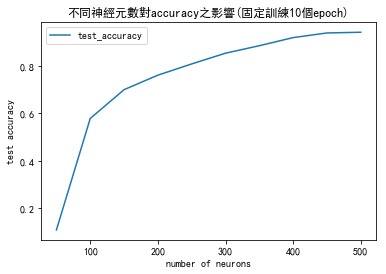

In [36]:
#coding:utf-8
plt.rcParams['font.sans-serif']=['SimHei']   # 設定中文字體
plt.title(u'不同神經元數對accuracy之影響(固定訓練10個epoch)')
plt.xlabel('number of neurons')
plt.ylabel('test accuracy')
plt.plot(np.arange(50, 501, 50), acc_list, label='test_accuracy')
plt.legend()
plt.show()

## 固定神經元個數為300，比較訓練不同 epoch 次數之影響，並畫出訓練過程loss與accuracy之變化

In [129]:
epoch_size = 200
input1 = Input(shape=(84,))
w1 = Dense(300, activation='relu', name='weight1')
dense1 = w1(input1)
w2 = Dense(48, activation='softmax', name='weight2')
output1 = w2(dense1)

model = Model(inputs=[input1], outputs=[output1])
model.compile(optimizer='adam', loss=['categorical_crossentropy'])

accuracy_list = []
train_loss_list = []
val_loss_list = []

for i in range(1, epoch_size+1):
    print('Epoch {}/{}'.format(i, epoch_size))
    h = model.fit(x=[ctrain_x], y=[ctrain_y], validation_data=[cvalid_x, cvalid_y])
    train_loss_list.append(h.history['loss'][0])
    val_loss_list.append(h.history['val_loss'][0])
    
    # 預測測試集
    predicted = model.predict(cvalid_x).reshape(cvalid_x.shape[0], 4, 12)
    # 將預測結果(one-hot編碼)轉回一般數值
    labels = []
    ans = []
    for i in range(0, len(valid_y)):
      labels.append(ctable.decode(valid_y[i]))
      ans.append(ctable.decode(predicted[i]))

    # 計算正確率
    acc = accuracy_score(ans, labels)
    print('accuracy: ', acc)
    accuracy_list.append(acc)


Epoch 1/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 15s 47us/step - loss: 8.4824 - val_loss: 7.3729
accuracy:  0.5236861861861862
Epoch 2/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 15s 46us/step - loss: 7.1383 - val_loss: 6.9652
accuracy:  0.6608983983983984
Epoch 3/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 15s 47us/step - loss: 6.8351 - val_loss: 6.7362
accuracy:  0.7203703703703703
Epoch 4/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 14s 44us/step - loss: 6.6663 - val_loss: 6.6123
accuracy:  0.7586461461461461
Epoch 5/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 13s 42us/step - loss: 6.5595 - val_loss: 6.5184
accuracy:  0.7899649649649649


accuracy:  0.9355855855855856
Epoch 42/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 19s 59us/step - loss: 6.0540 - val_loss: 6.0655
accuracy:  0.9367242242242242
Epoch 43/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 17s 55us/step - loss: 6.0510 - val_loss: 6.0584
accuracy:  0.9401151151151151
Epoch 44/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 19s 58us/step - loss: 6.0477 - val_loss: 6.0639
accuracy:  0.9397022022022022
Epoch 45/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 18s 56us/step - loss: 6.0450 - val_loss: 6.0489
accuracy:  0.9407157157157157
Epoch 46/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 18s 56us/step - loss: 6.0420 - val_loss: 6.

319680/319680 [==============================] - 17s 55us/step - loss: 5.9905 - val_loss: 6.0046
accuracy:  0.9497622622622622
Epoch 83/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 19s 58us/step - loss: 5.9902 - val_loss: 6.0051
accuracy:  0.9499124124124124
Epoch 84/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 17s 54us/step - loss: 5.9891 - val_loss: 6.0101
accuracy:  0.9501626626626627
Epoch 85/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 19s 58us/step - loss: 5.9889 - val_loss: 6.0006
accuracy:  0.9508258258258259
Epoch 86/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 18s 55us/step - loss: 5.9878 - val_loss: 5.9907
accuracy:  0.9521896896896896
Epoch 87/200
Train on 319680 samples, validate on 79920 samples
Epoch

319680/319680 [==============================] - 18s 57us/step - loss: 5.9655 - val_loss: 5.9922
accuracy:  0.9536411411411412
Epoch 124/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 19s 59us/step - loss: 5.9651 - val_loss: 5.9852
accuracy:  0.952977977977978
Epoch 125/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 18s 55us/step - loss: 5.9642 - val_loss: 5.9711
accuracy:  0.9551426426426426
Epoch 126/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 19s 59us/step - loss: 5.9636 - val_loss: 5.9713
accuracy:  0.955492992992993
Epoch 127/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 18s 55us/step - loss: 5.9631 - val_loss: 5.9789
accuracy:  0.9556806806806807
Epoch 128/200
Train on 319680 samples, validate on 79920 samples
Ep

319680/319680 [==============================] - 20s 62us/step - loss: 5.9467 - val_loss: 5.9645
accuracy:  0.9575700700700701
Epoch 165/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 21s 67us/step - loss: 5.9464 - val_loss: 5.9557
accuracy:  0.9566566566566567
Epoch 166/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 19s 61us/step - loss: 5.9461 - val_loss: 5.9595
accuracy:  0.9578328328328328
Epoch 167/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 21s 66us/step - loss: 5.9455 - val_loss: 5.9579
accuracy:  0.9568193193193193
Epoch 168/200
Train on 319680 samples, validate on 79920 samples
Epoch 1/1
319680/319680 [==============================] - 20s 63us/step - loss: 5.9461 - val_loss: 5.9591
accuracy:  0.958008008008008
Epoch 169/200
Train on 319680 samples, validate on 79920 samples
E

## 下方兩張圖:
## 第一張是隨著training epoch變多，訓練誤差和驗證誤差均持續降低。
## 第二張圖則是隨著training epoch變多，驗證accuracy持續上升至收斂

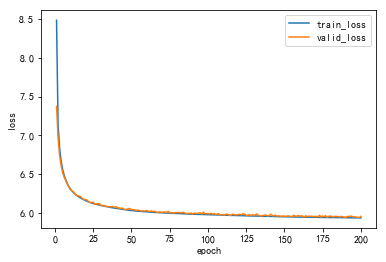

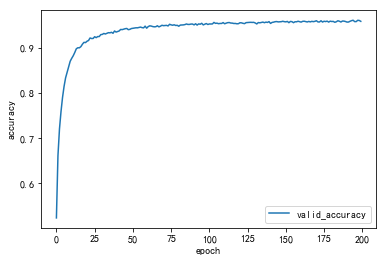

In [134]:
# 隨著 epoch 次數不同，loss 之變化
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(range(1, epoch_size+1, 1), train_loss_list, label='train_loss')
plt.plot(range(1, epoch_size+1, 1), val_loss_list, label='valid_loss')
plt.legend()
plt.show()

# 隨著 epoch 次數不同，accuracy 之變化
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.plot(accuracy_list, label='valid_accuracy' )
plt.legend()
plt.show()

## 使用測試集評估最終結果，accuracy 0.9597

In [135]:
# 預測測試集
predicted = model.predict(ctest_x).reshape(ctest_x.shape[0], 4, 12)
# 將預測結果(one-hot編碼)轉回一般數值
labels = []
ans = []
for i in range(0, len(ctest_y)):
  labels.append(ctable.decode(test_y[i]))
  ans.append(ctable.decode(predicted[i]))

# 計算正確率
acc = accuracy_score(ans, labels)
print('accuracy: ', acc)

accuracy:  0.9597297297297297
